In [67]:
import pandas as pd
import numpy as np
import math

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [68]:
udds = pd.read_csv("udds.csv", sep="\t")
udds

,Test Time (sec),Target Speed (mph)
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
...,...,...
1365,1365,5.2
1366,1366,2.5
1367,1367,0.0
1368,1368,0.0


In [69]:
# Vehicle
m = 1580.87  # kg
Cd = 0.259
A = 2.6005  # m^2
Crr = 0.008
# Battery
Rint = 0.373  # ohm
Q = 6.5 * 3600  # C
Voc = 219.7  # V

In [70]:
# Constants
rho = 1.2
g = 9.81

In [40]:
# Initial state of charge
SOC = 1.00

In [71]:
udds["Target Speed (m/s)"] = udds["Target Speed (mph)"] * 0.44704

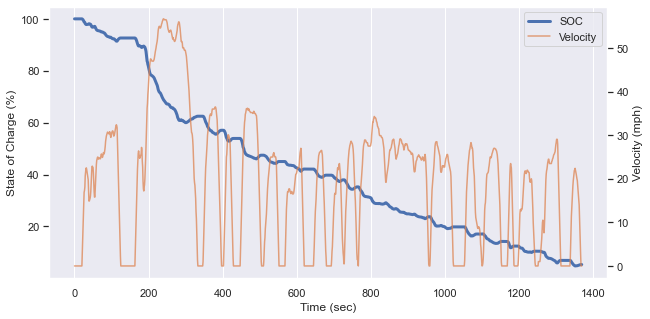

In [106]:
SOC = 1.00
SOC_list = []

for i in range(len(udds)):
    t = udds["Test Time (sec)"].iloc[i]
    v = udds["Target Speed (m/s)"].iloc[i]
    
    # Calculate acceleration
    if i == 0:
        dv = 0
        dt = 1
    else:
        t_prev = udds["Test Time (sec)"].iloc[i-1]
        v_prev = udds["Target Speed (m/s)"].iloc[i-1]

        dv = v - v_prev
        dt = t - t_prev
    a = dv/dt

    # Vehicle dynamics
    F_drag = 1/2 * Cd * rho * A * v**2
    F_rr = Crr * m*g
    F_prop = F_drag + F_rr + m*a

    # Power (neglecting efficiencies)
    P = F_prop * v
    """if P < 0:
        # Neglect regenerative braking
        P = 0"""
    if P < 0:
        # 50% efficient regenerative braking
        P *= 0.50

    # Battery current
    try:
        I = (Voc - math.sqrt(Voc**2 - 4*P*Rint))  /  (2*Rint)
    except ValueError:
        I = Voc / (2*Rint)


    # SOC
    dSOC = -I/Q * dt
    SOC += dSOC
    if SOC < 0:
        SOC = 0
    SOC_list.append(SOC)
SOC_array = np.array(SOC_list)


# Create axes
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()

# Disable grids
ax1.grid(which='major', axis='y')
ax2.grid(which='major', axis='y')

# Axis labels
ax1.set_xlabel("Time (sec)")
ax1.set_ylabel("State of Charge (%)")
ax2.set_ylabel("Velocity (mph)")

# Plot
line1 = ax1.plot(udds["Test Time (sec)"], SOC_array*100, label="SOC", linewidth=3)
line2 = ax2.plot(udds["Test Time (sec)"], udds["Target Speed (mph)"], color="C1", alpha=0.75, label="Velocity")

# Legend
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels)